In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import regex

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

In [5]:
data = pd.read_csv("/content/drive/Shareddrives/Facial Recognition/archive/feature.csv")

In [6]:
""" 
#### Variables

# userid: anonymous user id
# gender: self-reported, 1=female / 0=male
# age: self-reported, in 2019
# country: self-reported
# facial_hair: probability, see manuscript [11] Michal, Kosinski. "Facial recognition technology can expose political orientation from naturalistic facial images." Scientific Reports (Nature Publisher Group)
## Political views (0 = liberal / 1= conservative)
# pol: all samples
# pol_dat_[us/ca/uk]: dating sample, US/CA/UK
# pol_fb_us: Facebook sample, US                              
## Big 5Personality (standardized, mean=0, SD=1)
# ext: Extroversion 
# neu: Neuroticism
# ope: Openness
# agr: Agreeableness
# con: Conscientiousness 
# database: dating / fb 
## Following variables were estimated usingFacePlusPlus.com API (FPP)
# emotion.[sadness/neutral/disgust/anger/surprise/fear/happiness]: Emotional expression 
# gender.value: 1=female / 0=male
# age.value
# headpose.[yaw_angle/pitch_angle/roll_angle                    
# smile.value
# [left/right]_eye_status.[normal_glass_eye_open/no_glass_eye_close/occlusion/no_glass_eye_open/normal_glass_eye_close/dark_glasses]
# ethnicity.value" 

"""

' \n#### Variables\n\n# userid: anonymous user id\n# gender: self-reported, 1=female / 0=male\n# age: self-reported, in 2019\n# country: self-reported\n# facial_hair: probability, see manuscript [11] Michal, Kosinski. "Facial recognition technology can expose political orientation from naturalistic facial images." Scientific Reports (Nature Publisher Group)\n## Political views (0 = liberal / 1= conservative)\n# pol: all samples\n# pol_dat_[us/ca/uk]: dating sample, US/CA/UK\n# pol_fb_us: Facebook sample, US                              \n## Big 5Personality (standardized, mean=0, SD=1)\n# ext: Extroversion \n# neu: Neuroticism\n# ope: Openness\n# agr: Agreeableness\n# con: Conscientiousness \n# database: dating / fb \n## Following variables were estimated usingFacePlusPlus.com API (FPP)\n# emotion.[sadness/neutral/disgust/anger/surprise/fear/happiness]: Emotional expression \n# gender.value: 1=female / 0=male\n# age.value\n# headpose.[yaw_angle/pitch_angle/roll_angle                   

# prepare and clean data

In [8]:
def prepare_data(dataframe):
  # data prep 
  # y = dataframe['pol'].replace({"liberal":1,"conservative":0})

  # list of variables to be dropped 
  drop_col = ['Unnamed: 0', # index columns
              # 'pol',  # label column
              # 'gender', # self reported 
              # 'age', # self-reported 
              # 'country', # self reported 
              'userid', # index equivalent column 
              'pol_dat_us', # redundant columns with label
              'pol_dat_ca', # redundant columns with label
              'pol_dat_uk', # redundant columns with label
              'pol_fb_us', # redundant columns with label
              # 'database', # images acquisition 
              # 'ethnicity.value' # used later in the study
              ]

  X = dataframe.drop(drop_col, axis =1)

  # # getting the column names without the facial vectors for EDA 
  col_names = X.filter(regex ='V', axis =1 ).columns

  
  return X, col_names

In [9]:
df, image_col_names = prepare_data(data)

# EDA 

In [18]:
def stats(param):
  # takes the column name and gives out distribution plot and value counts 

  print("Stats")
  print(round(df[param].value_counts()/df.shape[0],2)*100)

  print()

  sns.countplot(df[param])
  plt.title("Distribution of {} ".format(param))
  plt.savefig("/content/drive/Shareddrives/Facial Recognition/eda/results/"+param+".png")



Stats
liberal         62.0
conservative    38.0
Name: pol, dtype: float64



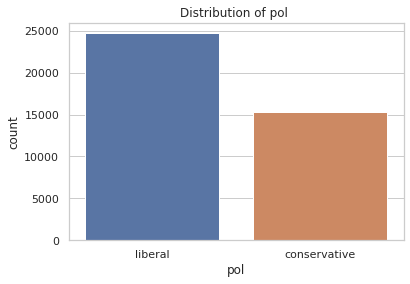

In [19]:
param = 'pol'

stats(param)

Stats
fb        59.0
dating    41.0
Name: database, dtype: float64



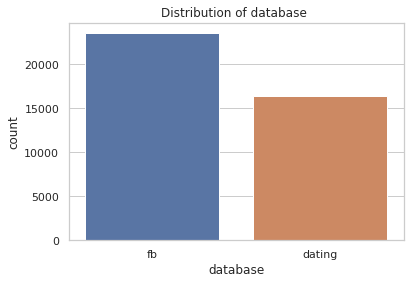

In [21]:
stats(param='database')

Stats
united states     95.0
united kingdom     3.0
canada             2.0
Name: country, dtype: float64



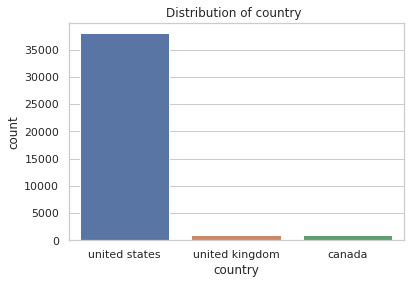

In [22]:
stats(param='country')

Text(0.5, 1.0, 'For Users in UK and Canada')

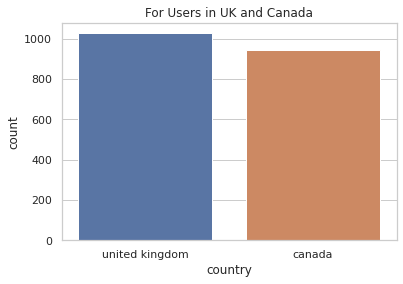

In [23]:
sns.countplot(df[df['country']!="united states"]['country'])
plt.title("For Users in UK and Canada")

Stats
1.0    76.0
0.0    24.0
Name: gender, dtype: float64



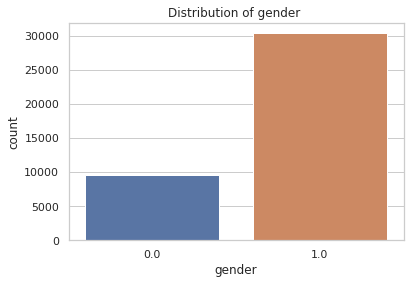

In [24]:
param = 'gender'
stats(param)



# Variable Analysis

## For continuous variables

In [25]:
# get all continuous data 
# removing columns image_col_names 
x_df = df.drop(image_col_names , axis =1)
con_df = x_df.loc[:,x_df.dtypes[(x_df.dtypes != 'object')].index]

con_df.head()

# liberal is 0 , conservative is 1

,gender,age,facial_hair,ext,neu,ope,agr,con,emotion.sadness,emotion.neutral,emotion.disgust,emotion.anger,emotion.surprise,emotion.fear,emotion.happiness,gender.value,age.value,headpose.yaw_angle,headpose.pitch_angle,headpose.roll_angle,smile.value,left_eye_status.normal_glass_eye_open,left_eye_status.no_glass_eye_close,left_eye_status.occlusion,left_eye_status.no_glass_eye_open,left_eye_status.normal_glass_eye_close,left_eye_status.dark_glasses,right_eye_status.normal_glass_eye_open,right_eye_status.no_glass_eye_close,right_eye_status.occlusion,right_eye_status.no_glass_eye_open,right_eye_status.normal_glass_eye_close,right_eye_status.dark_glasses
0,0.0,NaN,0.001713,1.022968,-1.084406,1.049730,0.265963,0.328752,0.0,99.0,0.0,0.0,0.4,0.0,0.5,1,38,9.7,5.0,-5.4,18.8,0.0,0.0,98.2,1.8,0.0,0.0,0.0,0.0,99.9,0.1,0.0,0.0
1,1.0,NaN,0.005151,0.367612,1.467204,0.532329,-2.072064,-0.724279,0.0,97.0,0.0,0.0,0.0,0.0,3.0,1,20,-3.2,11.9,2.8,29.6,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,0.0,NaN,0.977098,0.558261,-1.740534,-0.570139,0.650702,0.679762,0.0,0.0,0.0,0.0,99.6,0.4,0.0,0,70,1.0,12.9,3.6,4.7,14.6,0.0,69.6,0.3,0.0,15.5,39.7,0.0,0.0,0.0,0.0,60.2
3,1.0,24.36,0.000478,0.558261,0.634025,0.438256,-0.503514,-2.128320,0.0,0.0,0.3,1.7,96.9,0.3,0.8,1,30,5.1,12.9,-3.8,15.8,0.1,0.0,0.5,98.9,0.0,0.5,0.0,0.0,10.2,81.7,0.0,8.1
4,1.0,NaN,0.005617,1.301793,-0.990673,0.802995,-0.657410,1.171176,0.0,99.2,0.5,0.0,0.0,0.0,0.3,1,21,7.5,24.1,-2.1,71.5,0.0,0.0,99.9,0.0,0.0,0.0,2.3,0.0,97.3,0.1,0.1,0.2


In [26]:
######## eda for continuous
def con_eda(continuous_df):
    percentile=np.arange(0,1.01,0.05)
    ds1 = con_df.describe().loc[['count','mean','std'],:].transpose()
    ds2 = pd.DataFrame(con_df.skew())
    ds3 = pd.DataFrame(con_df.kurt())
    ds4 = pd.DataFrame(con_df.apply(pd.Series.nunique))
    ds5 = pd.DataFrame(con_df.isnull().sum()/con_df.shape[0])
    ds6 = pd.merge(ds1,ds2, left_index=True, right_index=True)
    ds7 = pd.merge(ds6,ds3, left_index=True, right_index=True)
    ds8 = pd.merge(ds7,ds4, left_index=True, right_index=True)
    ds9 = pd.merge(ds8,ds5, left_index=True, right_index=True)
    ds_final = ds9
    ds_final.columns = ('count','mean', 'std','skewness','kurtosis', "unique", "missing")
    D6 = ds_final
    return D6

In [27]:
eda_n = con_eda(con_df)

eda_n

,count,mean,std,skewness,kurtosis,unique,missing
gender,39879.0,0.760676,0.426676,-1.221953,-0.506856,2,0.003025
age,26913.0,33.889420,10.657514,1.113215,0.842594,3537,0.327175
facial_hair,40000.0,0.146950,0.299995,2.139727,2.919828,39946,0.000000
ext,21601.0,0.093325,1.018447,-0.428124,-0.347690,491,0.459975
neu,21601.0,0.117987,1.021163,0.131480,-0.453617,493,0.459975
ope,21601.0,-0.021225,1.063768,-0.716900,0.444374,401,0.459975
agr,21601.0,-0.022094,1.067648,-0.476537,0.115109,424,0.459975
con,21601.0,0.024486,1.033828,-0.187558,-0.375624,449,0.459975
emotion.sadness,40000.0,5.601895,17.931203,3.886237,14.713755,974,0.000000
emotion.neutral,40000.0,27.895712,38.564772,0.964527,-0.819589,1001,0.000000


In [28]:
eda_n

""" 
Skewness is a measure of the symmetry in a distribution. 
 A symmetrical dataset will have a skewness equal to 0.  
  So, a normal distribution will have a skewness of 0.   
    Skewness essentially measures the relative size of the two tails. 

Kurtosis : measures the amount of probability in the tails. 

If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails).

"""

' \nSkewness is a measure of the symmetry in a distribution. \n A symmetrical dataset will have a skewness equal to 0.  \n  So, a normal distribution will have a skewness of 0.   \n    Skewness essentially measures the relative size of the two tails. \n\nKurtosis : measures the amount of probability in the tails. \n\nIf the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails).\n\n'

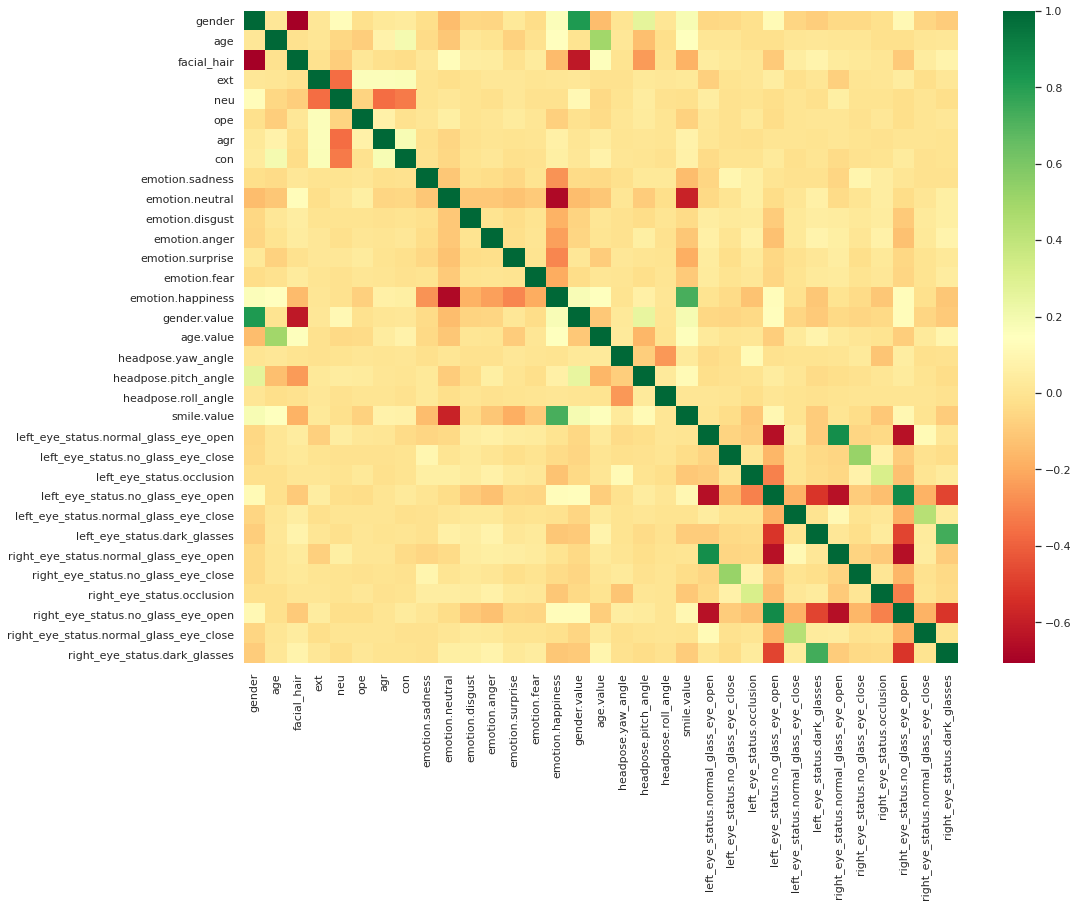

In [29]:
cor_mat = con_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor_mat, cmap='RdYlGn')
plt.savefig("/content/drive/Shareddrives/Facial Recognition/eda/results/correlation.png")

# Categorical Data 


In [30]:
cat_df = df.loc[:,df.dtypes[(df.dtypes == 'object')].index]
cat_df.shape

(40000, 4)

In [31]:
#eda for categorical
def cat_eda(cat_df):
    df1 = pd.DataFrame(cat_df.describe().transpose())
    df2 = pd.DataFrame(cat_df.isnull().sum())
    df_final = pd.merge(df1,df2, left_index=True, right_index=True)
    df_final.columns = ('count','unique','top','frequency','missing')
    return df_final

eda_c = cat_eda(cat_df)

In [32]:
eda_c.head()

,count,unique,top,frequency,missing
country,40000,3,united states,38027,0
pol,40000,2,liberal,24694,0
database,40000,2,fb,23557,0
ethnicity.value,40000,4,white,25154,0


In [33]:
#### population event rate
cat_df.groupby('pol').size()/len(cat_df)*100

pol
conservative    38.265
liberal         61.735
dtype: float64

In [34]:
def event_rate(data,column_name):
  grp = data.groupby(column_name)
  p = grp.apply(lambda x: pd.Series([x['pol'].count(), x.loc[x.pol=='liberal', 'pol'].count()], index=['count', 'event']))
  p['event_rate'] = p['event']/p['count']*100
  p_temp = p.loc[(p['event_rate'] >= 0) & (p['count'] >= 100),:]
  df_return = p_temp.sort_values(by='event_rate',ascending=False).head()

  return df_return


In [35]:
database_df = event_rate(cat_df,'database')

In [36]:
ethnicity_df = event_rate(cat_df,'ethnicity.value')

In [37]:
country_df = event_rate(cat_df,'country')

In [ ]:
# gender_df = event_rate(cat_df,'gender')

In [40]:
event_rate_df = pd.concat([database_df,ethnicity_df,country_df],axis = 0)

event_rate_df.to_csv("/content/drive/Shareddrives/Facial Recognition/eda/results/event_rate.csv")

In [41]:
###################### Chi-sq test ################################

label_encoder = LabelEncoder()

cat_df_1 = cat_df.copy()
cin = list(cat_df_1.columns)
for i in cin:
    cat_df_1[i] = label_encoder.fit_transform(cat_df_1[i].astype(str))
    

X = cat_df_1.drop('pol',axis=1)
y = cat_df_1['pol']
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

country             1.169060e-01
database            3.001851e-79
ethnicity.value    9.539853e-104
dtype: float64


In [ ]:
# country and gender are not significant in this analysis.

In [42]:
p_values.round(2)

country            0.12
database           0.00
ethnicity.value    0.00
dtype: float64